In [1]:
## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from unicodedata import normalize

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# contagem de aging
from collections import Counter

from IPython.display import display, HTML

## modelo
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import average_precision_score, mean_absolute_error, roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc
from sklearn.model_selection import cross_val_score

# check xgboost version
from xgboost import XGBClassifier, XGBRegressor

import dill as pickle

## alertas
import warnings
warnings.filterwarnings("ignore")

In [2]:
# %pip install xgboost==1.5.0

***
### Funções

In [3]:
def aucur(y_test, preds):
    # calculate AUC
    aucur = roc_auc_score(y_test, preds)
    print('AUC: %.3f' % aucur)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, preds)

    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    # show the plot
    plt.show()

In [4]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [5]:
def plot_feature_freq(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 0)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

In [6]:
def plot_feature_freq_mes(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1] + counts[2] + counts[3] + counts[4] + counts[5] + counts[6]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 0)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

***
## Coleta de dados

In [7]:
FILE = "/kaggle/input/bigdata/batdtfim_full.csv"

In [8]:
client_chunks = []
dados_teste = pd.read_csv(FILE, sep = ";", 
                          header = 0, 
                          index_col = False, 
                          names = None, 
                          low_memory = False, 
                          chunksize = 10**5) 

In [9]:
for chunk in dados_teste:

    new_clients = pd.DataFrame(chunk)

    # filter data chunk with frac percentage
#     new_clients = new_clients.sample(frac = 0.5)
    new_clients = new_clients.drop_duplicates()

    # saves to list
    client_chunks.append(new_clients)

dados = pd.concat(client_chunks).reset_index(drop = True)

In [10]:
# FILE = "/kaggle/input/datasetsnew/batdtfim500kage.csv"
# dados = pd.read_csv(FILE, sep = ';', encoding = 'ISO-8859-1', engine ='python')

dados = dados.rename(columns={'a.msisdn': 'msisdn'})\
             .rename(columns={'a.imsi': 'imsi'})\
             .rename(columns={'a.tac': 'tac'})\
             .rename(columns={'a.dt_inicio': 'dt_inicio'})\
             .rename(columns={'a.dt_fim': 'dt_fim'})\
             .rename(columns={'a.aging_aparelho': 'aging_aparelho'})\
             .rename(columns={'a.cat_aparelho': 'cat_aparelho'})\
             .rename(columns={'a.trocou_aparelho': 'trocou_aparelho'})\
             .rename(columns={'a.fabricante': 'fabricante'})\
             .rename(columns={'a.modelo': 'modelo'})\
             .rename(columns={'a.imei': 'imei'})\
             .rename(columns={'a.ranking': 'ranking'})\
             .rename(columns={'a.cpfidentifier': 'cpfidentifier'})\
             .rename(columns={'a.subscriberkey': 'subscriberkey'})\
             .rename(columns={'a.customerkey': 'customerkey'})\
             .rename(columns={'a.customersubtypedesc': 'customersubtypedesc'})\
             .rename(columns={'a.subscriberstatuskey': 'subscriberstatuskey'})\
             .rename(columns={'a.offertechnology': 'offertechnology'})\
             .rename(columns={'a.citydesc': 'citydesc'})\
             .rename(columns={'a.statedesc': 'statedesc'})\
             .rename(columns={'a.subscribermainofferdesc': 'subscribermainofferdesc'})\
             .rename(columns={'a.assignedchargeamount': 'assignedchargeamount'})\
             .rename(columns={'a.fl_3g': 'fl_3g'})\
             .rename(columns={'a.fl_4g': 'fl_4g'})\
             .rename(columns={'a.fl_5g': 'fl_5g'})\
             .rename(columns={'a.dt_ano_stts': 'dt_ano_stts'})\
             .rename(columns={'a.idade': 'idade'})\
             .rename(columns={'a.avg_msisdn': 'avg_msisdn'})\
             .rename(columns={'a.avg_cpf': 'avg_cpf'})\

dados

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf
0,5511910001022,724102007034575,35501610,2020-12-29,2022-02-12,13,1,1,SAMSUNG,"GALAXY S10E (SM-G970F,DS)",...,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 20GB+220GB BONUS,0.00,0.0,1.0,0.0,2018.0,54.0,13.0,13.0
1,5511910005207,724101993391706,35658611,2021-04-20,NaN,18,1,0,LG,LM-K420BMW,...,SAO PAULO,VIVO CONTROLE 7GB_,53.35,0.0,1.0,0.0,2020.0,35.0,0.0,0.0
2,5511910005218,724102090675583,35462311,2020-12-17,2022-03-24,15,1,1,Samsung Korea,GALAXY A10S,...,SAO PAULO,VIVO CONTROLE 4GB,37.61,0.0,1.0,0.0,2019.0,43.0,15.0,15.0
3,5511910010851,724100500592447,86135502,2021-10-16,NaN,12,1,0,Shenzhen Gionee Communication Equipment Co Ltd,GIONEE M100,...,SAO PAULO,VIVO CONTROLE DIG-7GB_,53.35,0.0,0.0,0.0,2013.0,80.0,0.0,0.0
4,5511910011500,724102091149832,35583108,2021-03-24,2022-04-19,12,1,1,APPLE,IPHONE 7 (A1660),...,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 10GB PLN+110GB BONUS,0.00,0.0,1.0,0.0,2016.0,62.0,0.0,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7909329,5599992311385,724119815091378,35570711,2021-06-24,NaN,15,1,0,SAMSUNG,"GALAXY A51 (SM-A515F,DSN)",...,MARANHAO,VIVO CONTROLE 7GB_,52.19,0.0,1.0,0.0,2020.0,41.0,17.0,17.0
7909330,5599992316211,724119891126964,35997108,2021-01-11,2022-04-26,15,1,1,SAMSUNG,GALAXY J7 NEO (SM-J701MT),...,MARANHAO,VIVO CTRL DIGITAL-11GB ILIM_,66.20,0.0,1.0,0.0,2017.0,43.0,15.0,15.0
7909331,5599992316415,724119892026372,86717405,2021-04-30,NaN,17,1,0,XIAOMI,REDMI 9A (M2006C3LG),...,MARANHAO,VIVO CONTROLE 7GB_,52.19,0.0,1.0,0.0,2020.0,34.0,0.0,0.0
7909332,5599996511912,724119107272077,35304309,2020-11-19,2022-03-05,15,1,1,APPLE,IPHONE X (A1901),...,MARANHAO,TITULAR VIVO V,1179.99,0.0,1.0,0.0,2017.0,40.0,15.0,15.0


### Limpeza dos dados

In [11]:
just_check_nan(dados)

Dados com NaN:
imsi                             1
dt_fim                     6634955
citydesc                   7909334
statedesc                      580
subscribermainofferdesc      13811
assignedchargeamount         12354
fl_3g                         1587
fl_4g                         1587
fl_5g                         1587
dt_ano_stts                   1587
idade                            3
dtype: int64

columns_with_nan.shape (11,)



In [12]:
dados_droped = dados.dropna(subset=['imsi',
                                    'statedesc', 
                                    'subscribermainofferdesc', 
                                    'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade'])\
                    .reset_index(drop=True)
# dados_droped

In [13]:
just_check_nan(dados_droped)

Dados com NaN:
dt_fim      6620112
citydesc    7892676
dtype: int64

columns_with_nan.shape (2,)



### Equilibrando classes

In [14]:
dados_droped_0 = dados_droped[dados_droped['trocou_aparelho'] == 0].sample(frac=0.40, random_state=3)
dados_droped_1 = dados_droped[dados_droped['trocou_aparelho'] == 1]

In [15]:
dados_droped = pd.concat([dados_droped_0, dados_droped_1]).reset_index(drop=True).sort_values(by='msisdn', ascending=False)
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf
840454,5599999896182,724119112725652,35299710,2021-04-17,NaN,18,1,0,SAMSUNG,GALAXY J6 PLUS (SM-J610F),...,MARANHAO,TITULAR VIVO FAMILIA 100GB,299.99,0.0,1.0,0.0,2018.0,43.0,0.0,0.0
436271,5599999895337,724119897499129,35686411,2021-06-17,NaN,16,1,0,APPLE,IPHONE 11 (A2111),...,MARANHAO,VIVO CONTROLE 4GB,36.86,0.0,1.0,0.0,2020.0,29.0,0.0,0.0
932924,5599999893979,724119891736125,35444089,2021-08-14,NaN,14,1,0,APPLE,IPHONE 12 PRO MAX (A2342),...,MARANHAO,LINHA ADICIONAL VIVO FAMILIA 150GB - MENSAL,0.00,0.0,0.0,1.0,2021.0,64.0,0.0,0.0
1139129,5599999893093,724119893248935,35900309,2021-09-16,NaN,13,1,0,HMD Global Oy,TA-1333,...,MARANHAO,VIVO CTRL DIGITAL-11GB ILIM_,66.20,0.0,1.0,0.0,2020.0,44.0,0.0,0.0
3236070,5599999891775,724119892858749,86814005,2021-03-25,2022-06-07,14,1,1,XIAOMI,POCO X3 NFC (M2007J20CT),...,MARANHAO,VIVO CONTROLE 11GB - ANUAL,66.20,0.0,1.0,0.0,2020.0,48.0,0.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3320787,5511910000251,724102900236484,35912453,2020-12-21,2022-04-12,15,1,1,Samsung Korea,GALAXY S20 FE,...,SAO PAULO,LINHA ADICIONAL VIVO V,0.00,0.0,1.0,0.0,2020.0,42.0,15.0,14.5
3009656,5511910000251,724102900236484,35912453,2020-12-21,2022-04-12,15,1,1,Samsung Korea,GALAXY S20 FE,...,SAO PAULO,LINHA ADICIONAL VIVO V,0.00,0.0,1.0,0.0,2020.0,42.0,0.0,14.5
2981192,5511910000251,724102900236484,35912453,2020-12-21,2022-04-12,15,1,1,Samsung Korea,GALAXY S20 FE,...,SAO PAULO,LINHA ADICIONAL VIVO V,0.00,0.0,1.0,0.0,2020.0,42.0,14.0,14.5
3236071,5511910000068,724102900228343,35634809,2021-01-14,2022-03-09,13,1,1,SAMSUNG,GALAXY J5 PRIME DUOS (SM-G570M DS),...,SAO PAULO,VIVO CONTROLE 9GB I,57.01,0.0,1.0,0.0,2018.0,43.0,6.5,6.5


In [16]:
dados_droped = dados_droped.tail(dados_droped.shape[0] -5500000).reset_index(drop=True)
dados_droped['dt_ano_stts'] = dados_droped['dt_ano_stts'].astype(np.int64).reset_index(drop=True)
dados_droped['idade'] = np.asarray(dados_droped['idade'], dtype = 'int16')
dados_droped['fl_3g'] = np.asarray(dados_droped['fl_3g'], dtype = 'int8')
dados_droped['fl_4g'] = np.asarray(dados_droped['fl_4g'], dtype = 'int8')
dados_droped['fl_5g'] = np.asarray(dados_droped['fl_5g'], dtype = 'int8')
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf
0,5543996327299,724064191621628,35614110,2021-06-21,NaN,15,1,0,SAMSUNG,"GALAXY A30 (SM-A305GT,DS)",...,PARANA,VIVO CONTROLE 7GB_,56.27,0,1,0,2019,36,0.0,0.00
1,5543996326700,724064004871663,35282311,2021-03-27,NaN,18,1,0,APPLE,IPHONE 11 PRO (A2215),...,PARANA,TITULAR VIVO V,876.70,0,1,0,2019,28,12.0,17.29
2,5543996326700,724064004871663,35282311,2021-03-27,NaN,18,1,0,APPLE,IPHONE 11 PRO (A2215),...,PARANA,TITULAR VIVO V,876.70,0,1,0,2019,28,0.0,17.29
3,5543996326700,724064004871663,35282311,2021-03-27,NaN,18,1,0,APPLE,IPHONE 11 PRO (A2215),...,PARANA,TITULAR VIVO V,876.70,0,1,0,2019,28,63.0,17.29
4,5543996326700,724064004871663,35282311,2021-03-27,NaN,18,1,0,APPLE,IPHONE 11 PRO (A2215),...,PARANA,TITULAR VIVO V,876.70,0,1,0,2019,28,26.0,17.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445977,5511910000251,724102900236484,35912453,2020-12-21,2022-04-12,15,1,1,Samsung Korea,GALAXY S20 FE,...,SAO PAULO,LINHA ADICIONAL VIVO V,0.00,0,1,0,2020,42,15.0,14.50
2445978,5511910000251,724102900236484,35912453,2020-12-21,2022-04-12,15,1,1,Samsung Korea,GALAXY S20 FE,...,SAO PAULO,LINHA ADICIONAL VIVO V,0.00,0,1,0,2020,42,0.0,14.50
2445979,5511910000251,724102900236484,35912453,2020-12-21,2022-04-12,15,1,1,Samsung Korea,GALAXY S20 FE,...,SAO PAULO,LINHA ADICIONAL VIVO V,0.00,0,1,0,2020,42,14.0,14.50
2445980,5511910000068,724102900228343,35634809,2021-01-14,2022-03-09,13,1,1,SAMSUNG,GALAXY J5 PRIME DUOS (SM-G570M DS),...,SAO PAULO,VIVO CONTROLE 9GB I,57.01,0,1,0,2018,43,6.5,6.50


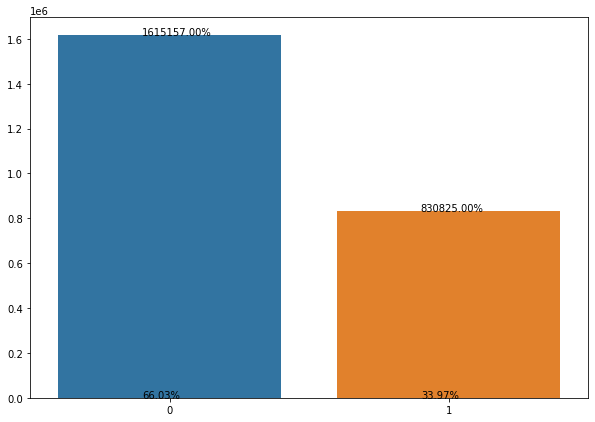

In [17]:
# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho')

In [18]:
dados_droped['dt_ano_stts'].unique()

array([2019, 2020, 2018, 2017, 2021, 2016, 2010, 2015, 2014, 2011, 2013,
       2012, 2007, 2001, 2009, 2008, 2006, 2003, 2005, 2004, 1999, 2022])

***
## Exploração dos dados

### seleção de features

In [19]:
# define features
X_ta = dados_droped[['avg_cpf', 'ranking', 'avg_msisdn', 'aging_aparelho']]

# X_ta = dados_droped[['fabricante', 'ranking', 'aging_aparelho', 
#                      'avg_msisdn', 'avg_cpf',
#                      'dt_ano_stts']]

X_ta

,avg_cpf,ranking,avg_msisdn,aging_aparelho
0,0.00,1,0.0,15
1,17.29,1,12.0,18
2,17.29,1,0.0,18
3,17.29,1,63.0,18
4,17.29,1,26.0,18
...,...,...,...,...
2445977,14.50,1,15.0,15
2445978,14.50,1,0.0,15
2445979,14.50,1,14.0,15
2445980,6.50,1,6.5,13


In [20]:
X_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2445982 entries, 0 to 2445981
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   avg_cpf         float64
 1   ranking         int64  
 2   avg_msisdn      float64
 3   aging_aparelho  int64  
dtypes: float64(2), int64(2)
memory usage: 74.6 MB


#### Variaveis Categoricas

In [21]:
# Get list of categorical variables
s_ta = (X_ta.dtypes == 'object')
object_cols_ta = list(s_ta[s_ta].index)
print("Categorical variables: ", len(object_cols_ta))
print(object_cols_ta)

Categorical variables:  0
[]


#### Variaveis Numéricas

In [22]:
# Criando uma lista de variaveis numéricas
numerical_cols_ta = [cname for cname in X_ta.columns if X_ta[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols_ta))
print(numerical_cols_ta)

Numerical variables:  4
['avg_cpf', 'ranking', 'avg_msisdn', 'aging_aparelho']


***
***
***
## Definição do Target trocou_aparelho

In [23]:
# define target
y_trocou_aparelho = dados_droped['trocou_aparelho']

c_trocou_aparelho = Counter(y_trocou_aparelho)
c_trocou_aparelho

Counter({0: 1615157, 1: 830825})

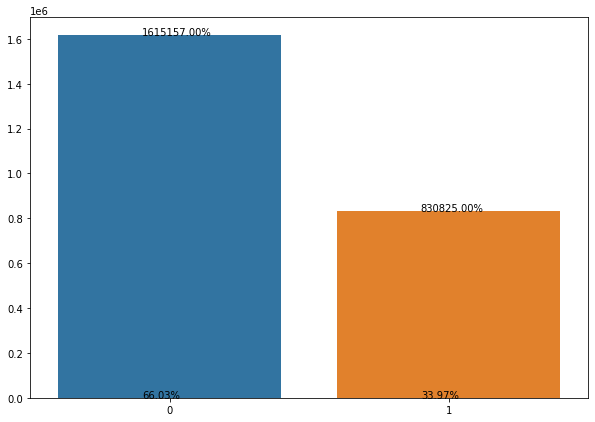

In [24]:
# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho')

***
## Modelagem trocou_aparelho

In [25]:
# Dividindo as features em dados de treino e teste
X_train_ta, X_val_ta, y_train_ta, y_val_ta = train_test_split(X_ta, 
                                                              y_trocou_aparelho, 
                                                              test_size=0.5, 
                                                              random_state = 2048)

# Pré-processamento para Dados Numéricos
numerical_transformer_ta = Pipeline([
                                     ('scaler', StandardScaler())
                                    ])

# Pré-processamento para Dados Categóricos
categorical_transformer_ta = Pipeline([
                                       ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
                                      ])

# Pré-processamento de pacote de dados numéricos e categóricos
preprocessor_ta = ColumnTransformer(transformers=[
                                                  ('num', numerical_transformer_ta, numerical_cols_ta),
                                                  ('cat', categorical_transformer_ta, object_cols_ta)
                                                 ], n_jobs=-1)

pipeline_ta = Pipeline(steps=[
                              ('preprocessor', preprocessor_ta),
                              ('smote', SMOTE(random_state=42, n_jobs=-1)),
                              ('model', XGBClassifier(random_state=2048, n_jobs=-1))
                             ])

# Preprocessing of training data, fit model 
pipeline_ta.fit(X_train_ta, y_train_ta)

# Predictions
# preds = np.asarray(pipeline.predict(X_val), dtype = 'int')
preds_ta = pipeline_ta.predict(X_val_ta)

[18:07:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Save Model

In [26]:
# Use pickle to save model for next usage.
filename = 'model_trocou_aparelho.pk'
with open('./'+filename, 'wb') as file:
    pickle.dump(pipeline_ta, file) 

In [27]:
train_yhat_ta = pipeline_ta.predict(X_train_ta)
train_acc_ta = accuracy_score(y_train_ta, train_yhat_ta)
print('Training Acuracy:', train_acc_ta)
val_acc_ta = accuracy_score(y_val_ta, preds_ta)
print('Validation Acuracy:', val_acc_ta)

Training Acuracy: 0.9662761214105419
Validation Acuracy: 0.9657168368369023


In [28]:
c_train_ta = Counter(y_train_ta)
c_train_ta

Counter({1: 414776, 0: 808215})

In [29]:
c_val_ta = Counter(y_val_ta)
c_val_ta


Counter({0: 806942, 1: 416049})

In [30]:
c_preds_ta = Counter(preds_ta)
c_preds_ta

Counter({0: 785096, 1: 437895})

***
## Métricas

AUC: 0.968


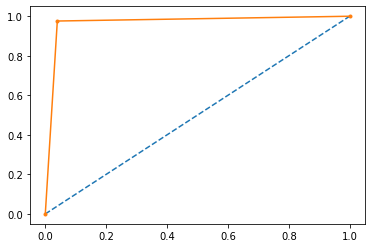

In [31]:
aucur(y_val_ta, preds_ta)

In [32]:
# # Multiply by -1 since sklearn calculates *negative* MAE
# scores = -1 * cross_val_score(pipeline_ta, X_val_ta, y_val_ta,
#                               cv=5, n_jobs=-1, verbose=2,
#                               scoring='f1')

# print("MAE scores:\n", scores)

In [33]:
print(classification_report(y_val_ta, preds_ta))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97    806942
           1       0.93      0.98      0.95    416049

    accuracy                           0.97   1222991
   macro avg       0.96      0.97      0.96   1222991
weighted avg       0.97      0.97      0.97   1222991



In [34]:
cm_df_ta = pd.DataFrame(confusion_matrix(y_val_ta, preds_ta),
                     index = sorted(Counter(y_val_ta)),
                     columns = sorted(Counter(preds_ta)))
cm_df_ta

,0,1
0,775055,31887
1,10041,406008


Confusion matrix, without normalization
[[775055  31887]
 [ 10041 406008]]
Normalized confusion matrix
[[0.96048415 0.03951585]
 [0.02413418 0.97586582]]


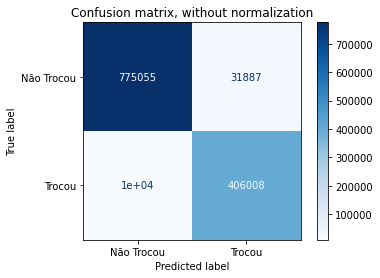

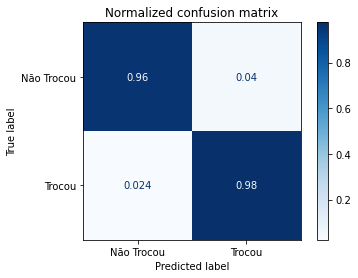

<Figure size 1296x1296 with 0 Axes>

In [35]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline_ta,
        X_val_ta,
        y_val_ta,
        display_labels=['Não Trocou', 'Trocou'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

***
***
***
### Testes com outros dados

In [36]:
FILE_teste = "/kaggle/input/datasetsnew/pca_tem_clientes_iphone_aging.csv"

In [37]:
client_chunks_teste = []
dados_teste2 = pd.read_csv(FILE_teste, sep = ";", 
                          header = 0, 
                          index_col = False, 
                          names = None, 
                          low_memory = False, 
                          chunksize = 10**5) 

In [38]:
for chunk2 in dados_teste2:

    new_clients2 = pd.DataFrame(chunk2)

    # filter data chunk with frac percentage
    new_clients2 = new_clients2.sample(frac = 0.7)
    new_clients2 = new_clients2.drop_duplicates()

    # saves to list
    client_chunks_teste.append(new_clients2)

dados_val = pd.concat(client_chunks_teste).reset_index(drop = True)

In [39]:
dados_val = dados_val.rename(columns={'a.msisdn': 'msisdn'})\
                     .rename(columns={'a.imsi': 'imsi'})\
                     .rename(columns={'a.tac': 'tac'})\
                     .rename(columns={'a.dt_inicio': 'dt_inicio'})\
                     .rename(columns={'a.dt_fim': 'dt_fim'})\
                     .rename(columns={'a.aging_aparelho': 'aging_aparelho'})\
                     .rename(columns={'a.cat_aparelho': 'cat_aparelho'})\
                     .rename(columns={'a.trocou_aparelho': 'trocou_aparelho'})\
                     .rename(columns={'a.fabricante': 'fabricante'})\
                     .rename(columns={'a.modelo': 'modelo'})\
                     .rename(columns={'a.imei': 'imei'})\
                     .rename(columns={'a.ranking': 'ranking'})\
                     .rename(columns={'a.cpfidentifier': 'cpfidentifier'})\
                     .rename(columns={'a.subscriberkey': 'subscriberkey'})\
                     .rename(columns={'a.customerkey': 'customerkey'})\
                     .rename(columns={'a.customersubtypedesc': 'customersubtypedesc'})\
                     .rename(columns={'a.subscriberstatuskey': 'subscriberstatuskey'})\
                     .rename(columns={'a.offertechnology': 'offertechnology'})\
                     .rename(columns={'a.citydesc': 'citydesc'})\
                     .rename(columns={'a.statedesc': 'statedesc'})\
                     .rename(columns={'a.subscribermainofferdesc': 'subscribermainofferdesc'})\
                     .rename(columns={'a.assignedchargeamount': 'assignedchargeamount'})\
                     .rename(columns={'a.fl_3g': 'fl_3g'})\
                     .rename(columns={'a.fl_4g': 'fl_4g'})\
                     .rename(columns={'a.fl_5g': 'fl_5g'})\
                     .rename(columns={'a.dt_ano_stts': 'dt_ano_stts'})\
                     .rename(columns={'a.age': 'idade'})\
                     .rename(columns={'a.avg_msisdn': 'avg_msisdn'})\
                     .rename(columns={'a.avg_cpf': 'avg_cpf'})\
        #              .drop_duplicates().reset_index(drop=True)

dados_val

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf,a.peso_aparelho,a.update_software
0,5591999429517,724119897821334,35482609,2021-09-02,NaN,13,1,0,APPLE,IPHONE 7 (A1778),...,71.99,0,1,0,2018,36,0.0,0.0,1778,0
1,5531996136614,724234291985460,35293111,2021-04-17,NaN,18,1,0,APPLE,IPHONE 11 (A2221),...,66.34,0,1,0,2020,33,0.0,0.0,2221,1
2,5511984360681,724102006919162,35672811,2021-03-26,NaN,18,1,0,APPLE,IPHONE 12 PRO MAX (A2411),...,159.99,0,0,1,2020,35,0.0,0.0,2411,1
3,5511994419096,724100003684837,35260470,2021-09-07,NaN,13,1,0,APPLE,IPHONE 11 (A2221),...,0.00,0,1,0,2021,47,0.0,0.0,2221,1
4,5582982347736,724118597628007,35479015,2021-09-05,NaN,13,1,0,APPLE,IPHONE 11 (A2221),...,60.99,0,1,0,2021,35,0.0,0.0,2221,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778656,5524999454945,724112911068954,35307810,2021-08-09,NaN,14,1,0,APPLE,IPHONE XR (A2105),...,51.52,0,1,0,2018,27,0.0,0.0,2105,1
778657,5561996568274,724066791587256,35868409,2021-01-04,2022-06-12,17,1,1,APPLE,IPHONE 7 (A1778),...,56.18,0,1,0,2018,23,17.0,17.0,1778,0
778658,5585981161398,724118113072797,35380008,2021-09-03,NaN,13,1,0,APPLE,IPHONE 6S (A1688),...,32.49,0,1,0,2016,18,0.0,0.0,1688,0
778659,5511943057119,724102110672745,35298409,2021-05-24,2022-06-07,12,1,1,APPLE,IPHONE 7 (A1778),...,92.99,0,1,0,2017,26,12.0,12.0,1778,0


In [40]:
dados_outros_anos = dados_val[dados_val['dt_ano_stts'] != 2020]
dados_outros_anos['dt_ano_stts'].unique()

array([2018, 2021, 2019, 2017, 2016, 2015, 2014, 2012, 2013, 2011, 2008,
       2010, 2009, 2007])

In [41]:
# dados_outros_anos = dados[dados['dt_ano_stts'] != 2020]
# dados_outros_anos['dt_ano_stts'].unique()

In [42]:
# just_check_nan(dados_outros_anos)
just_check_nan(dados_outros_anos)

Dados com NaN:
dt_fim                     444149
citydesc                   509732
statedesc                      41
subscribermainofferdesc      1273
assignedchargeamount         1229
dtype: int64

columns_with_nan.shape (5,)



In [43]:
dados_val = dados_outros_anos.dropna(subset=['imsi',
                                             'statedesc', 
                                             'subscribermainofferdesc', 
                                             'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade'])\
                             .reset_index(drop=True)
# dados_droped

In [44]:
just_check_nan(dados_val)

Dados com NaN:
dt_fim      442909
citydesc    508357
dtype: int64

columns_with_nan.shape (2,)



In [45]:
# dados_val = dados_val.tail(dados_val.shape[0] -3000000).reset_index(drop=True)
dados_val['dt_ano_stts'] = dados_val['dt_ano_stts'].astype(np.int64).reset_index(drop=True)
dados_val['idade'] = np.asarray(dados_val['idade'], dtype = 'int16')
dados_val['fl_3g'] = np.asarray(dados_val['fl_3g'], dtype = 'int8')
dados_val['fl_4g'] = np.asarray(dados_val['fl_4g'], dtype = 'int8')
dados_val['fl_5g'] = np.asarray(dados_val['fl_5g'], dtype = 'int8')

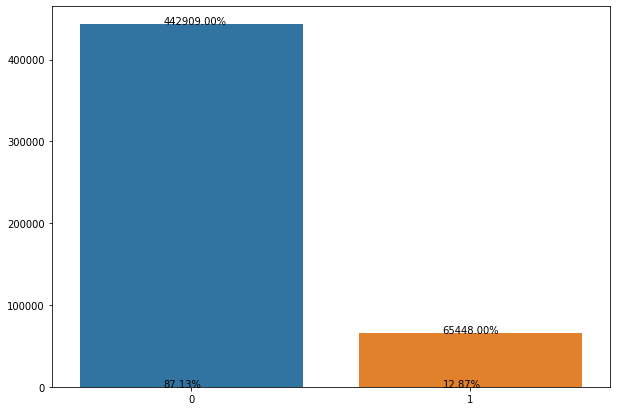

In [46]:
# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_val, 'trocou_aparelho')

In [47]:
X_teste = dados_val.drop('trocou_aparelho', axis=1)

y_teste = dados_val['trocou_aparelho']

In [48]:
preds_val = pipeline_ta.predict(X_teste)
preds_val

array([0, 0, 0, ..., 0, 1, 0])

AUC: 0.985


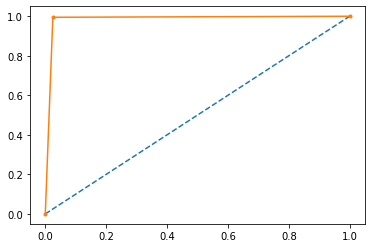

In [49]:
aucur(y_teste, preds_val)

In [50]:
print(classification_report(y_teste, preds_val))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    442909
           1       0.86      0.99      0.92     65448

    accuracy                           0.98    508357
   macro avg       0.93      0.98      0.95    508357
weighted avg       0.98      0.98      0.98    508357



Confusion matrix, without normalization
[[431920  10989]
 [   342  65106]]
Normalized confusion matrix
[[0.97518903 0.02481097]
 [0.00522552 0.99477448]]


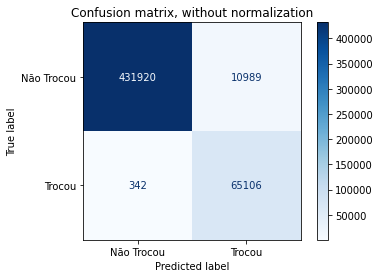

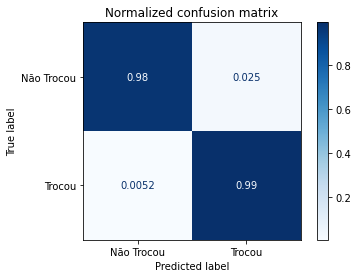

<Figure size 1296x1296 with 0 Axes>

In [51]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline_ta,
        X_teste,
        y_teste,
        display_labels=['Não Trocou', 'Trocou'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

***
***
***
## Captação dos clientes que foram previstos como Propensos a Fazer uma Compra

Base Original

In [52]:
X_val_ta['trocou_aparelho'] = y_val_ta
# X_val_ta

<Figure size 576x432 with 0 Axes>

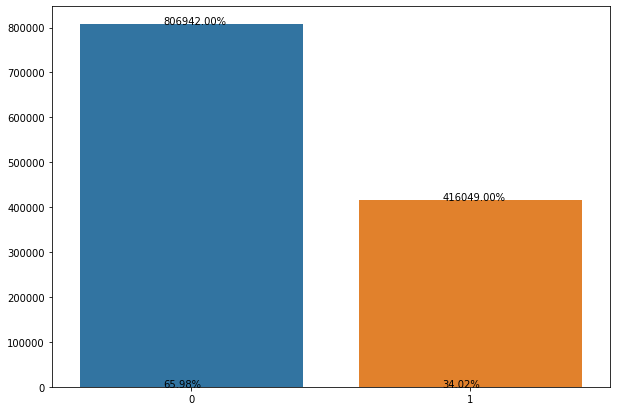

In [53]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho')

Base Prevista

In [54]:
X_val_ta['trocou_aparelho_previsto'] = preds_ta
# X_val_ta

<Figure size 576x432 with 0 Axes>

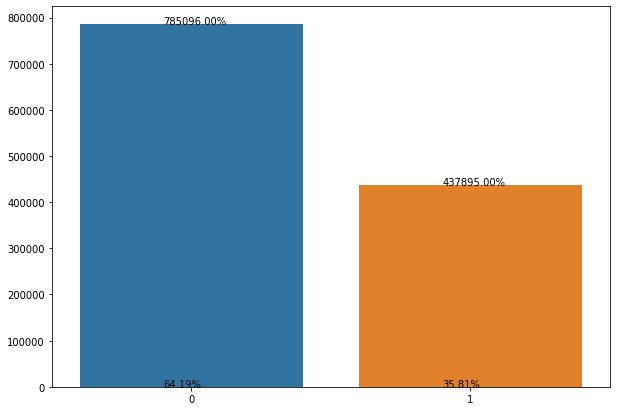

In [55]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho_previsto')

In [56]:
X_val_ta['cpfidentifier'] = dados_droped['cpfidentifier']
# X_val_ta

In [57]:
X_val_ta['dt_inicio'] = dados_droped['dt_inicio']
# X_val_ta

In [58]:
X_val_ta['dt_fim'] = dados_droped['dt_fim']
X_val_ta['modelo'] = dados_droped['modelo']
X_val_ta['fabricante'] = dados_droped['fabricante']
X_val_ta['subscribermainofferdesc'] = dados_droped['subscribermainofferdesc']
X_val_ta['assignedchargeamount'] = dados_droped['assignedchargeamount']
X_val_ta['offertechnology'] = dados_droped['offertechnology']
X_val_ta['statedesc'] = dados_droped['statedesc']
X_val_ta['fl_3g'] = dados_droped['fl_3g']
X_val_ta['fl_4g'] = dados_droped['fl_4g']
X_val_ta['fl_5g'] = dados_droped['fl_5g']
X_val_ta['idade'] = dados_droped['idade']
X_val_ta['avg_msisdn'] = dados_droped['avg_msisdn']
X_val_ta['avg_cpf'] = dados_droped['avg_cpf']

X_val_ta

,avg_cpf,ranking,avg_msisdn,aging_aparelho,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim,modelo,fabricante,subscribermainofferdesc,assignedchargeamount,offertechnology,statedesc,fl_3g,fl_4g,fl_5g,idade
971667,0.00,1,0.0,12,0,0,10844133701,2021-09-26,NaN,REDMI 8 (M1908C3IG),XIAOMI,VIVO CONTROLE 11GB I,71.99,Controle,RIO DE JANEIRO,0,1,0,37
353521,11.00,1,14.0,14,1,1,39219712687,2020-12-30,2022-03-29,GALAXY J5 2017 (SM-J530G DS),SAMSUNG,VIVO CONTROLE 9GB I,55.87,Controle,MINAS GERAIS,0,1,0,60
859428,0.00,2,0.0,17,1,1,98605194715,2021-05-04,NaN,GALAXY S20 FE (SM-G780F),SAMSUNG,TITULAR VIVO_POS 30GB,134.99,PostPaid,ESPIRITO SANTO,0,1,0,85
243443,10.67,1,8.0,16,1,1,6884367652,2020-11-14,2022-04-13,REDMI NOTE 8 (M1908C3JG),XIAOMI,VIVO CONTROLE 7GB_,52.31,Controle,MINAS GERAIS,0,1,0,37
814676,0.00,1,0.0,15,0,0,15854209721,2021-07-09,NaN,L9 (5159J),TCL,VIVO CONTROLE 6GB III,45.99,Controle,ESPIRITO SANTO,0,1,0,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738834,22.00,1,22.0,16,0,0,18054353880,2021-05-31,NaN,NAIROBI20,"Motorola Mobility LLC, a Lenovo Company",VIVO CONTROLE 7GB_,53.35,Controle,SAO PAULO,0,1,0,45
949527,0.00,1,0.0,16,0,0,14228421776,2021-05-24,NaN,REDMI NOTE 10,Xiaomi Communications Co Ltd,VIVO CONTROLE 4GB IV,32.49,Controle,RIO DE JANEIRO,0,1,0,22
49944,0.00,1,0.0,16,0,0,7623820907,2021-06-19,NaN,K10 2017 (M250DS),LG,VIVO CONTROLE 4GB IV,34.99,Controle,PARANA,0,1,0,31
1673440,0.00,1,0.0,15,0,0,2944886851,2021-07-02,NaN,"GALAXY J2 CORE (SM-J260M,DS)",SAMSUNG,VIVO CONTROLE 4GB IV,32.49,Controle,SAO PAULO,0,1,0,64


In [59]:
train_yhat_ta = pipeline_ta.predict(X_train_ta)
train_acc_ta = accuracy_score(y_train_ta, train_yhat_ta)
print('Training Acuracy:', train_acc_ta)
val_acc_ta = accuracy_score(y_val_ta, preds_ta)
print('Validation Acuracy:', val_acc_ta)
teste_acc_ta = accuracy_score(y_teste, preds_val)
print('Test Acuracy:', teste_acc_ta)

Training Acuracy: 0.9662761214105419
Validation Acuracy: 0.9657168368369023
Test Acuracy: 0.9777105459352384


***
***
***
## Separando as bases para outro modelo

In [60]:
base_to_pred_month = X_val_ta[X_val_ta['trocou_aparelho_previsto'] == 1].reset_index(drop=True)
base_to_pred_month

,avg_cpf,ranking,avg_msisdn,aging_aparelho,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim,modelo,fabricante,subscribermainofferdesc,assignedchargeamount,offertechnology,statedesc,fl_3g,fl_4g,fl_5g,idade
0,11.00,1,14.0,14,1,1,39219712687,2020-12-30,2022-03-29,GALAXY J5 2017 (SM-J530G DS),SAMSUNG,VIVO CONTROLE 9GB I,55.87,Controle,MINAS GERAIS,0,1,0,60
1,0.00,2,0.0,17,1,1,98605194715,2021-05-04,NaN,GALAXY S20 FE (SM-G780F),SAMSUNG,TITULAR VIVO_POS 30GB,134.99,PostPaid,ESPIRITO SANTO,0,1,0,85
2,10.67,1,8.0,16,1,1,6884367652,2020-11-14,2022-04-13,REDMI NOTE 8 (M1908C3JG),XIAOMI,VIVO CONTROLE 7GB_,52.31,Controle,MINAS GERAIS,0,1,0,37
3,16.00,1,16.0,16,1,1,14101775729,2021-02-03,2022-06-13,GUAM+20,"Motorola Mobility LLC, a Lenovo Company",VIVO CONTROLE 7GB_,51.52,Controle,RIO DE JANEIRO,0,1,0,23
4,16.00,1,0.0,16,1,1,25447682827,2020-11-19,2022-03-23,GALAXY ON7 REFRESH (SM-G611MT DS),SAMSUNG,VIVO CONTROLE 7GB_,61.99,Controle,SAO PAULO,0,1,0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437890,18.00,1,18.0,18,1,1,597215618,2020-10-17,2022-04-26,LG-A275,LG,VIVO CONTROLE 7GB_,52.31,Controle,MINAS GERAIS,0,0,0,73
437891,16.00,1,0.0,16,1,1,82951667604,2021-01-05,2022-05-29,GALAXY A11,Samsung Korea,VIVO CONTROLE 6GB III,50.99,Controle,MINAS GERAIS,0,1,0,60
437892,0.00,2,0.0,13,1,1,4050899965,2021-09-11,NaN,"GALAXY A22 (SM-A225F,DS)",SAMSUNG,VIVO CONTROLE 4GB,36.26,Controle,PARANA,0,1,0,40
437893,0.00,2,0.0,16,1,1,292066694,2021-06-18,NaN,SGH-N105,SAMSUNG,Linha Adicional Vivo Pós Família 180GB,0.00,PostPaid,MINAS GERAIS,0,1,0,48


***
***
***
## Definição do Target aging_aparelho

In [61]:
# define target
y = base_to_pred_month['aging_aparelho']

In [62]:
# contagem de aging
from collections import Counter

c = Counter(y)
c

Counter({14: 64160,
         17: 56437,
         16: 58970,
         13: 68478,
         18: 51971,
         15: 61086,
         12: 76793})

<Figure size 1440x432 with 0 Axes>

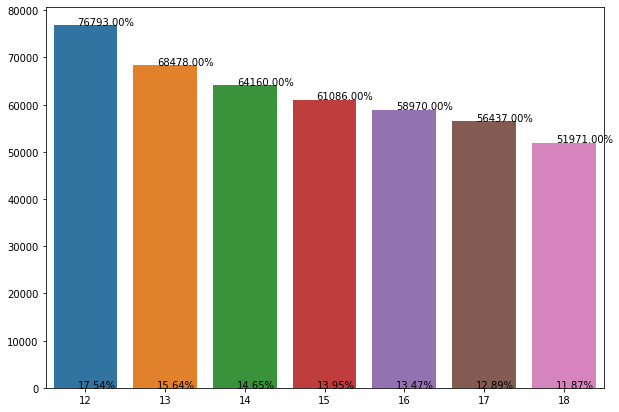

In [63]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq_mes(base_to_pred_month, 'aging_aparelho')

### Definicão das features

In [64]:
# define features
X = base_to_pred_month[['ranking', 'avg_msisdn', 'avg_cpf', 'assignedchargeamount']]

# X = base_to_pred_month[['fabricante', 'ranking', 'modelo', 'avg_msisdn', 'avg_cpf',
#                         'assignedchargeamount']]

X

,ranking,avg_msisdn,avg_cpf,assignedchargeamount
0,1,14.0,11.00,55.87
1,2,0.0,0.00,134.99
2,1,8.0,10.67,52.31
3,1,16.0,16.00,51.52
4,1,0.0,16.00,61.99
...,...,...,...,...
437890,1,18.0,18.00,52.31
437891,1,0.0,16.00,50.99
437892,2,0.0,0.00,36.26
437893,2,0.0,0.00,0.00


#### Variaveis Categoricas

In [65]:
# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables: ", len(object_cols))
print(object_cols)

Categorical variables:  0
[]


#### Variaveis Numéricas

In [66]:
# Criando uma lista de variaveis numéricas
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols))
print(numerical_cols)

Numerical variables:  4
['ranking', 'avg_msisdn', 'avg_cpf', 'assignedchargeamount']


***
## Modelagem

In [67]:
# Dividindo as features em dados de treino e teste - 70% para dados de treinamento e 30% para dados de teste
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.5, 
                                                  random_state = 2048)

# Pré-processamento para Dados Numéricos
numerical_transformer = Pipeline([
                                  ('scaler', StandardScaler())
                                 ])

# Pré-processamento para Dados Categóricos
categorical_transformer = Pipeline([
                                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
                                   ])

# Pré-processamento de pacote de dados numéricos e categóricos
preprocessor = ColumnTransformer(transformers=[
                                                ('num', numerical_transformer, numerical_cols),
                                                ('cat', categorical_transformer, object_cols)
                                              ], n_jobs=-1)

pipeline = Pipeline(steps=[
                            ('preprocessor', preprocessor),
                            ('smote', SMOTE(random_state=42, n_jobs=-1)),   # equilibrar
                            ('model', XGBClassifier(random_state=2048, n_jobs=-1))
                          ])

# Preprocessing of training data, fit model 
pipeline.fit(X_train, y_train)

# Predictions
#preds = np.asarray(pipeline.predict(X_val), dtype = 'int')
preds = pipeline.predict(X_val)

[18:09:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Save Model

In [68]:
# Use pickle to save model for next usage.
filename2 = 'model_aging.pk'
with open('./'+filename2, 'wb') as file:
    pickle.dump(pipeline, file) 

In [69]:
c_train = Counter(y_train)
c_train

Counter({14: 32055,
         12: 38234,
         16: 29451,
         13: 34412,
         18: 25904,
         15: 30673,
         17: 28218})

In [70]:
c_val = Counter(y_val)
c_val

Counter({16: 29519,
         13: 34066,
         18: 26067,
         14: 32105,
         12: 38559,
         17: 28219,
         15: 30413})

In [71]:
c_preds = Counter(preds)
c_preds

Counter({13: 30850,
         18: 27450,
         14: 30508,
         15: 28989,
         12: 42322,
         16: 28804,
         17: 30025})

<Figure size 1440x432 with 0 Axes>

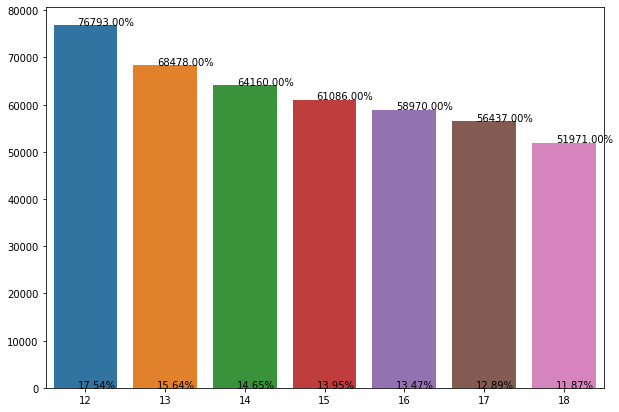

In [72]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq_mes(base_to_pred_month, 'aging_aparelho')

***
## Métricas

In [73]:
# # Multiply by -1 since sklearn calculates *negative* MAE
# scores = -1 * cross_val_score(pipeline, X_val, y_val,
#                               cv=5, n_jobs=-1, verbose=2,
#                               scoring='f1')

# print("MAE scores:\n", scores)

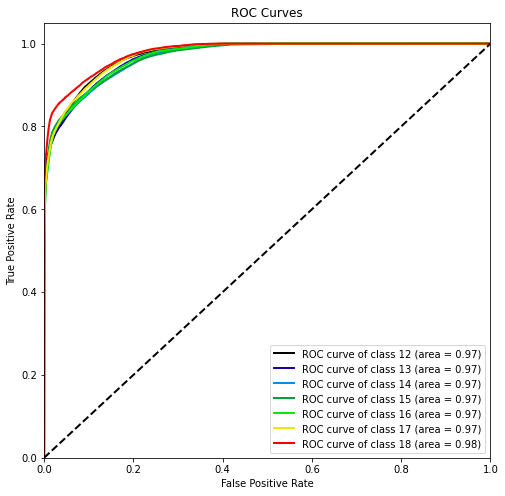

In [74]:
y_probas = pipeline.predict_proba(X_val)
plot_roc(y_val, y_probas, plot_micro = False, plot_macro = False, figsize = (8, 8))
plt.show()

In [75]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

          12       0.76      0.84      0.80     38559
          13       0.85      0.77      0.81     34066
          14       0.83      0.79      0.81     32105
          15       0.83      0.79      0.81     30413
          16       0.81      0.79      0.80     29519
          17       0.75      0.80      0.78     28219
          18       0.80      0.84      0.82     26067

    accuracy                           0.80    218948
   macro avg       0.81      0.80      0.80    218948
weighted avg       0.81      0.80      0.80    218948



In [76]:
cm_df = pd.DataFrame(confusion_matrix(y_val, preds),
                     index = sorted(Counter(y_val)),
                     columns = sorted(Counter(preds)))
cm_df

,12,13,14,15,16,17,18
12,32288,1822,1250,809,573,1079,738
13,2923,26243,1653,1068,550,970,659
14,1641,713,25290,1311,1432,1120,598
15,1338,563,831,24084,1610,1311,676
16,1230,537,620,726,23391,1880,1135
17,1566,539,456,593,706,22658,1701
18,1336,433,408,398,542,1007,21943


## Plot non-normalized confusion matrix

In [77]:
y.unique()

array([14, 17, 16, 13, 18, 15, 12])

Confusion matrix, without normalization
[[32288  1822  1250   809   573  1079   738]
 [ 2923 26243  1653  1068   550   970   659]
 [ 1641   713 25290  1311  1432  1120   598]
 [ 1338   563   831 24084  1610  1311   676]
 [ 1230   537   620   726 23391  1880  1135]
 [ 1566   539   456   593   706 22658  1701]
 [ 1336   433   408   398   542  1007 21943]]
Normalized confusion matrix
[[0.83736611 0.04725226 0.03241785 0.02098083 0.01486034 0.02798309
  0.0191395 ]
 [0.08580403 0.77035754 0.04852345 0.03135091 0.01614513 0.02847414
  0.0193448 ]
 [0.05111353 0.02220838 0.78772777 0.04083476 0.04460364 0.03488553
  0.01862638]
 [0.04399434 0.01851182 0.02732384 0.7918982  0.05293789 0.04310657
  0.02222734]
 [0.04166808 0.01819167 0.02100342 0.02459433 0.79240489 0.06368779
  0.03844981]
 [0.05549452 0.01910061 0.01615933 0.02101421 0.0250186  0.80293419
  0.06027854]
 [0.05125254 0.01661104 0.01565197 0.01526835 0.02079257 0.03863122
  0.8417923 ]]


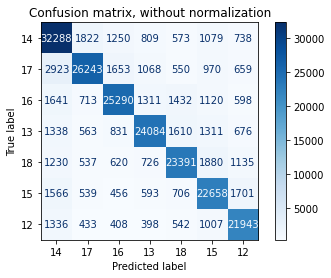

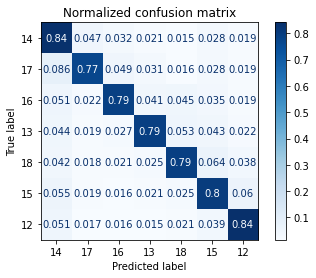

<Figure size 1800x1800 with 0 Axes>

In [78]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X_val,
        y_val,
        display_labels=y.unique(),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(25, 25))
plt.show()

***
## Mesclando resultados com tabela

### Com a base de validação

In [79]:
X_val['aging_aparelho'] = y_val
# X_val

In [80]:
X_val['previsto'] = preds
# X_val

In [81]:
X_val['cpfidentifier'] = base_to_pred_month['cpfidentifier']
# X_val

In [82]:
X_val['dt_inicio'] = base_to_pred_month['dt_inicio']
# X_val

In [83]:
X_val['dt_fim'] = base_to_pred_month['dt_fim']
# X_val

## Calculando data prevista

In [84]:
X_val['dt_fim_previsto'] = ((pd.to_datetime(X_val['dt_inicio']).dt.to_period('M')) + X_val['previsto'])
X_val

,ranking,avg_msisdn,avg_cpf,assignedchargeamount,aging_aparelho,previsto,cpfidentifier,dt_inicio,dt_fim,dt_fim_previsto
86914,2,0.0,0.00,109.99,16,13,1176345818,2021-06-06,NaN,2022-07
183006,1,9.5,10.75,0.00,16,18,98508571704,2020-10-04,2022-02-24,2022-04
100058,1,7.0,7.00,32.49,13,14,30314834800,2021-03-04,2022-04-06,2022-05
3778,1,0.0,13.00,60.87,13,13,93040474634,2021-02-06,2022-04-01,2022-03
337396,1,18.0,18.00,67.60,18,18,37996781826,2020-08-10,2022-02-17,2022-02
...,...,...,...,...,...,...,...,...,...,...
274403,1,9.0,9.00,51.52,17,18,91182964753,2020-09-02,2022-02-08,2022-03
209141,1,17.0,20.50,235.13,17,17,14276010896,2021-01-14,2022-06-18,2022-06
66643,1,18.0,18.00,60.99,18,18,10931927714,2020-11-03,2022-05-16,2022-05
20819,1,7.5,14.25,51.52,15,15,3444013752,2021-02-22,2022-06-10,2022-05


In [85]:
c_preds

Counter({13: 30850,
         18: 27450,
         14: 30508,
         15: 28989,
         12: 42322,
         16: 28804,
         17: 30025})

<Figure size 1440x432 with 0 Axes>

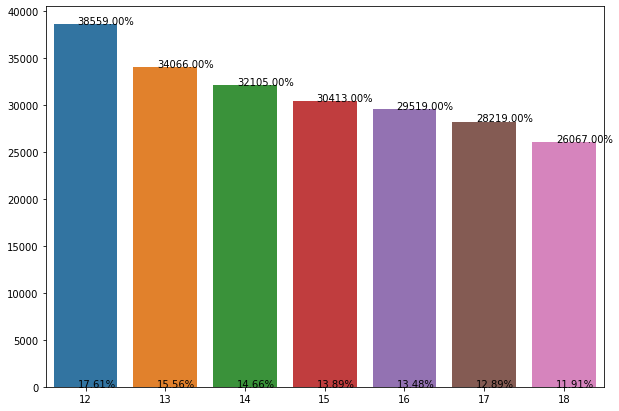

In [86]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq_mes(X_val, 'aging_aparelho')

<Figure size 1440x432 with 0 Axes>

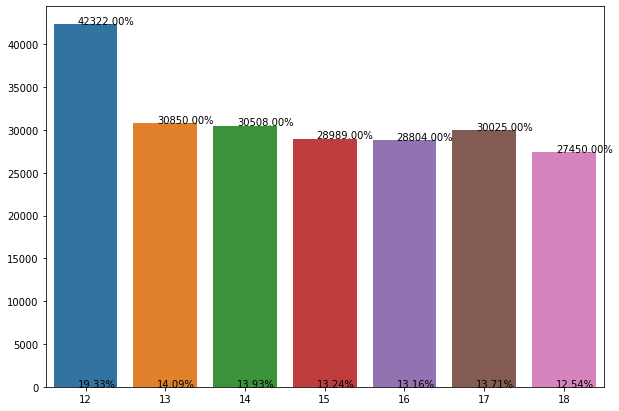

In [87]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq_mes(X_val, 'previsto')

***
***
***
### Teste com outra base

In [88]:
dados_val_mes = dados_val[dados_val['trocou_aparelho'] == 1].reset_index(drop=True)

X_teste_mes = dados_val_mes.drop(['trocou_aparelho', 'aging_aparelho'], axis=1)

y_teste_mes = dados_val_mes['aging_aparelho']

In [89]:
preds_val_mes = pipeline.predict(X_teste_mes)
preds_val_mes

array([12, 15, 16, ..., 12, 17, 12])

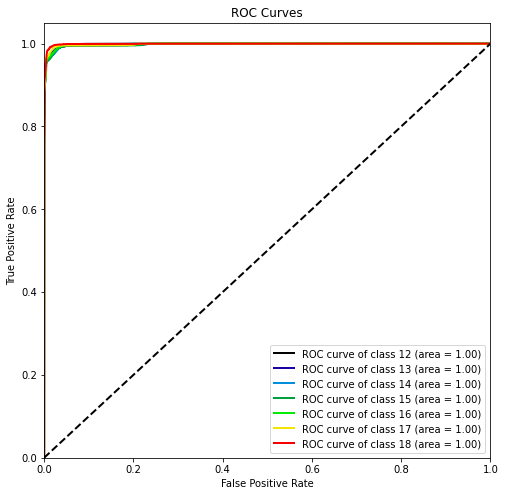

In [90]:
y_probas = pipeline.predict_proba(X_teste_mes)
plot_roc(y_teste_mes, y_probas, plot_micro = False, plot_macro = False, figsize = (8, 8))
plt.show()

In [91]:
print(classification_report(y_teste_mes, preds_val_mes))

              precision    recall  f1-score   support

          12       0.98      0.95      0.96     10452
          13       0.97      0.96      0.97      9924
          14       0.96      0.95      0.96      9365
          15       0.96      0.96      0.96      9255
          16       0.96      0.97      0.96      8982
          17       0.96      0.97      0.96      8764
          18       0.95      0.99      0.97      8706

    accuracy                           0.96     65448
   macro avg       0.96      0.96      0.96     65448
weighted avg       0.96      0.96      0.96     65448



In [92]:
dados_val_mes['dt_ano_stts'].unique()

array([2018, 2017, 2019, 2016, 2015, 2012, 2013, 2014, 2021, 2011, 2010,
       2009])

Confusion matrix, without normalization
[[9934  271  132   68   27    9   11]
 [  30 9565  167   94   52   14    2]
 [  41   29 8939  182  116   48   10]
 [  38   10   34 8863  162   98   50]
 [  33    9   11    8 8668  151  102]
 [  19    4    1   10   22 8461  247]
 [  56    9   17   12   18   13 8581]]
Normalized confusion matrix
[[9.50440107e-01 2.59280520e-02 1.26291619e-02 6.50593188e-03
  2.58323766e-03 8.61079219e-04 1.05243016e-03]
 [3.02297461e-03 9.63825071e-01 1.68278920e-02 9.47198710e-03
  5.23982265e-03 1.41072148e-03 2.01531640e-04]
 [4.37800320e-03 3.09663641e-03 9.54511479e-01 1.94340630e-02
  1.23865456e-02 5.12546716e-03 1.06780566e-03]
 [4.10588871e-03 1.08049703e-03 3.67368990e-03 9.57644516e-01
  1.75040519e-02 1.05888709e-02 5.40248514e-03]
 [3.67401470e-03 1.00200401e-03 1.22467157e-03 8.90670229e-04
  9.65041193e-01 1.68114006e-02 1.13560454e-02]
 [2.16795984e-03 4.56412597e-04 1.14103149e-04 1.14103149e-03
  2.51026928e-03 9.65426746e-01 2.81834779e-02]
 [6.4

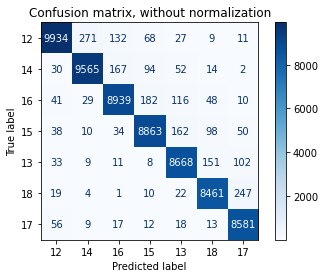

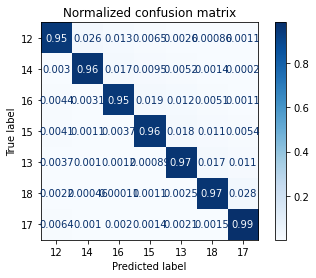

<Figure size 1296x1296 with 0 Axes>

In [93]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X_teste_mes,
        y_teste_mes,
        display_labels=y_teste_mes.unique(),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

In [94]:
train_yhat = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, train_yhat)
print('Training Acuracy:', train_acc)
val_acc = accuracy_score(y_val, preds)
print('Validation Acuracy:', val_acc)
teste_acc = accuracy_score(y_teste, preds_val)
print('Test Acuracy:', teste_acc)

Training Acuracy: 0.8173256541537449
Validation Acuracy: 0.8033734037305662
Test Acuracy: 0.9777105459352384
